# After exploring the dataset, now we will be exploring the ways in which to preprocess the images in the dataset before running it through the neural network model. 

In [226]:
import os
import glob
import datetime
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Convolution2D, Dropout, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import os
from tensorflow.keras.losses import Loss
from keras_preprocessing import image
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from pathlib import Path
import re
import time
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import matplotlib.image as mpimg

In [ ]:

! pip install -q kaggle

In [ ]:
!ls

kaggle.json  sample_data


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'robinreni/signature-verification-dataset/versions/2?resource=download' -p sign --unzip

 97% 585M/601M [00:05<00:00, 130MB/s]
100% 601M/601M [00:05<00:00, 124MB/s]


In [ ]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [ ]:
os.listdir() #list directories and files 

['.config', 'kaggle.json', 'sign', 'sample_data']

In [ ]:
test_dir = '/content/sign/sign_data/test'
test_csv = '/content/sign/sign_data/test_data.csv'
train_dir = '/content/sign/sign_data/train'
train_csv = '/content/sign/sign_data/train_data.csv'


# 3 Pre Processing 
I will be exploring some image preprocessing methods using a sample image from the data set before applying to the entire dataset. 

## 1) Color Space Conversion 
## 2) Resize Image 

# Sample Image Preprocessing 

## View sample image from the training dataset


In [ ]:
sample = '/content/sign/sign_data/sign_data/train/001/001_01.PNG' #path of image 
img1 = cv2.imread(sample) #reading an image in default mode 

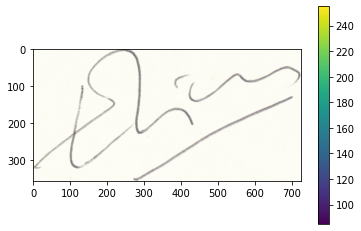

In [ ]:
plt.figure()
plt.imshow(img1) #display image
plt.colorbar()
plt.grid(False)
plt.show()

#Color Space Conversion
##Converting images to grayscale

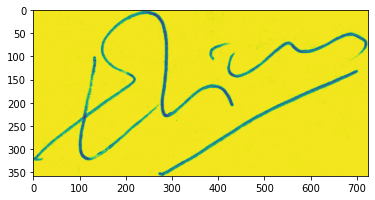

In [ ]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #using cv2.color_bgr2gray color space to convert from one color space to 
plt.imshow(img1) #display image 

Using cv2.color_BGR2GRAY returns a yellow and green image instead of gray because matplotlib is expecting a 3 channel RGB matrix to be shown, but the sample image is a single channel matrix.

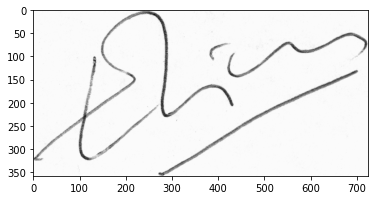

In [ ]:
plt.imshow(img1, cmap='gray')

#Resize Image

## Resize images to 100 * 100

In [ ]:
img1 = cv2.resize(img1, (100, 100))   ##resize to 100 X 100 pixels 

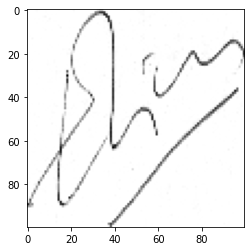

In [ ]:
plt.imshow(img1, cmap='gray') #display image

# 4 Siamese Network
### I intend to build a siamese network first to identify whether the signature is a forgery or not. By comparing two signatures, we will be asking the neural network if the signature comes from the same individual. The siamese network will work well in this scenario because it can be trained with little data. As we have noticed in the previous notebook, there is an average of around 16 genuine signatures and 12 forgery signatures from each individual. As such, we do not have enough data from each individual to train the model, which could likely result in an overfit. 

## First, I will create a function in which to separate the images in the train and test data according to the way in which the csv files have been formatted. 

In [ ]:
def read_data(dir, data):
    images1 = [] 
    images2 = [] 
    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir,data.iat[j, 0]) #identify file path of image
        img1 = cv2.imread(path) #read image
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #color space conversion 
        img1 = cv2.resize(img1, (100, 100)) #resizing of image 
        images1.append([img1]) #add to images1
        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])
        labels.append(np.array(data.iat[j, 2]))
    images1 = np.array(images1).astype(np.float32) / 255.0 #normalization of images1
    images2 = np.array(images2).astype(np.float32) / 255.0 #nornmalization of images2
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels

#Next, apply the function for both train and test data

In [ ]:
df_train = pd.read_csv('/content/sign/sign_data/train_data.csv', header=None)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)
train_labels = to_categorical(train_labels)


In [ ]:
df_test = pd.read_csv('/content/sign/sign_data/test_data.csv', header=None)
test_images1, test_images2, test_labels = read_data(dir=test_dir, data=df_test)


#Sample Images to show forged signatures and genuine signatures

In [ ]:
print(df_train.iloc[1200, :])
img_org = df_train.iloc[1200, 0]
img_frg = df_train.iloc[1200, 1]

0             062/09_062.png
1    062_forg/01_0109062.PNG
2                          1
Name: 1200, dtype: object


Text(0.5, 1.0, 'forged signature - individual 062')

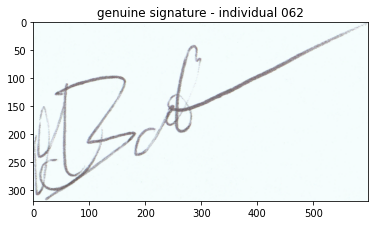

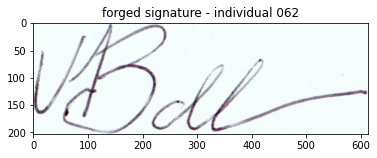

In [ ]:
img_original = plt.imread('/content/sign/sign_data/train/'+img_org)
img_forged = plt.imread('/content/sign/sign_data/train/'+img_frg)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_original)
plt.title("genuine signature - individual 062")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_forged)
plt.title("forged signature - individual 062")

In [ ]:
#shuffle
train_images1, train_images2, train_labels = shuffle(train_images1, train_images2, train_labels)
test_images1, test_images2, test_labels = shuffle(test_images1, test_images2, test_labels)

#
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)
test_images1 = test_images1.reshape(-1, size, size, 1)
test_images2 = test_images2.reshape(-1, size, size, 1)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# I will try the basic generic model with 2 convolution layers

In [ ]:
def build_base_network(input_shape):
    seq = Sequential()

    kernel_size = 3

    seq.add(Convolution2D(64, (kernel_size, kernel_size), input_shape=input_shape)) #First convolution extracts 64 filters that are 3*3, convolution followed by activation and max cooling layer with 2 * 2 window. 
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Convolution2D(32, (kernel_size, kernel_size))) #First convolution extracts 32 filters that are 3*3, convolution followed by activation and max cooling layer with 2 * 2 window. 
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten
    seq.add(Flatten()) #flatten feature map
    seq.add(Dense(128, activation='relu')) 
    seq.add(Dense(64, activation='relu'))
    return seq

In [ ]:
input_dim = (100, 100, 1) #input shape is 100X100 with 1 color channel
base_network = build_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
vec_a = base_network(img_a)
vec_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vec_a, vec_b])
prediction = Dense(2, activation='softmax')(distance)
model = Model([img_a, img_b], prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           2194272     ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

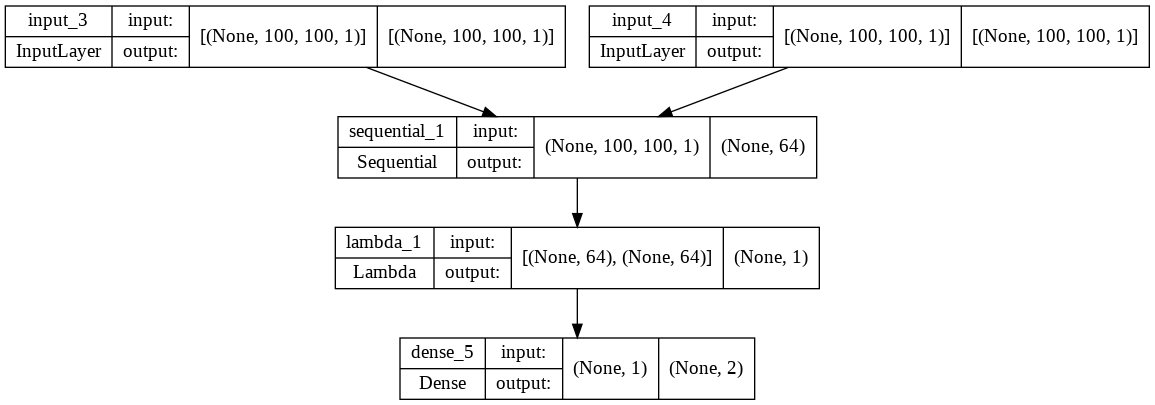

In [ ]:
plot_model(model, to_file='model_plot_withouthBathNormalizationDropout.png', show_shapes=True, show_layer_names=True)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00008)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
history1 = model.fit([train_images1,train_images2],train_labels,validation_split=.30,batch_size=32,epochs=40)

Epoch 1/40
508/508 [==============================] - 12s 22ms/step - loss: 0.6900 - accuracy: 0.5419 - val_loss: 0.6825 - val_accuracy: 0.5457
Epoch 2/40
508/508 [==============================] - 9s 18ms/step - loss: 0.6733 - accuracy: 0.5419 - val_loss: 0.6749 - val_accuracy: 0.5457
Epoch 3/40
508/508 [==============================] - 9s 18ms/step - loss: 0.6626 - accuracy: 0.5419 - val_loss: 0.6730 - val_accuracy: 0.5457
Epoch 4/40
508/508 [==============================] - 9s 18ms/step - loss: 0.6551 - accuracy: 0.5440 - val_loss: 0.6717 - val_accuracy: 0.5487
Epoch 5/40
508/508 [==============================] - 9s 18ms/step - loss: 0.6484 - accuracy: 0.5590 - val_loss: 0.6712 - val_accuracy: 0.5536
Epoch 6/40
508/508 [==============================] - 10s 21ms/step - loss: 0.6420 - accuracy: 0.5878 - val_loss: 0.6707 - val_accuracy: 0.5623
Epoch 7/40
508/508 [==============================] - 10s 21ms/step - loss: 0.6360 - accuracy: 0.6168 - val_loss: 0.6727 - val_accuracy: 0.5

In [ ]:
pred_y = model.predict([test_images1,test_images2])
predict = np.argmax(pred_y, axis =1 )
accuracy_score(predict , test_labels)

0.7261656228253306

# The train accuracy score is much higher than the val accuracy which means that the model is overfitting. This is due to the lack of volume in data as the data is slightly more than 1.5 thousand images.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(test_labels, pred_y.argmax(axis=1))
print('Acc: {:.4f}'.format(acc))

Acc: 0.7262


In [ ]:
cf_matrix = confusion_matrix(test_labels, pred_y.argmax(axis=1))
print(confusion_matrix(test_labels, pred_y.argmax(axis=1)))

[[2288  484]
 [1090 1886]]


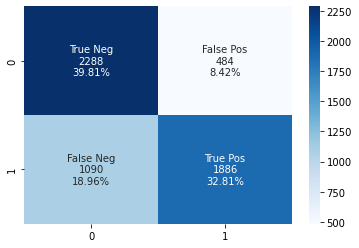

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

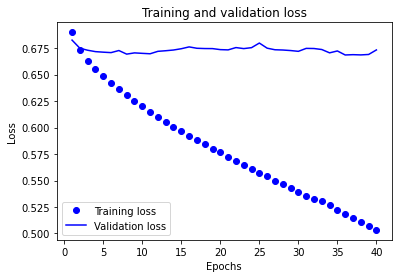

In [ ]:
history_dict = history1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history1.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


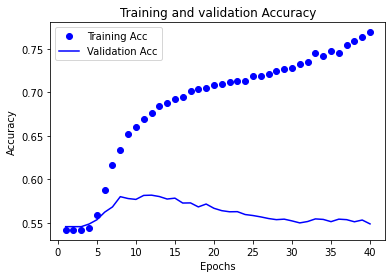

In [ ]:
history_dict = history1.history
loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, (len(history1.history['accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training Acc')
plt.plot(epochs, val_loss_values, 'b', label='Validation Acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#The model is most likely overfitting as the train loss and val loss are very far away from each other. The gap between training and validation accuracy is a clear indication of overfitting. The larger the gap, the higher the overfitting.

# testing model on sample images

Image label: Genuine 068/09_068.png
Image label: Forgery 068_forg/03_0113068.PNG
[[0.410862 0.589138]]
1
Not Similar


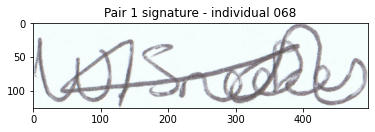

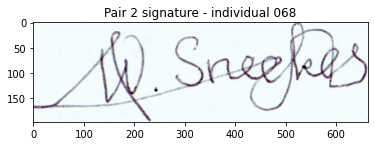

In [ ]:
pair_1 = df_test.iloc[0, 0]
pair_2 = df_test.iloc[0, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 068")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 068")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 067/07_067.png
Image label: Genuine 067/04_067.png
[[0.6193625 0.3806375]]
0
Similar


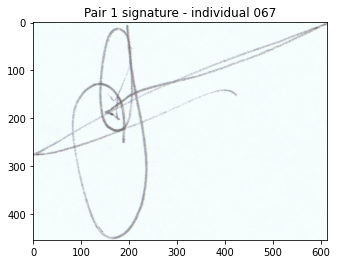

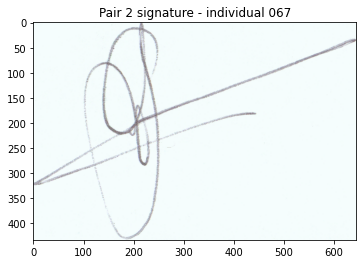

In [ ]:
pair_1 = df_test.iloc[1200, 0]
pair_2 = df_test.iloc[1200, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 067")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 067")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 058/04_058.png
Image label: Genuine 058/03_058.png
[[0.7846271  0.21537298]]
0
Similar


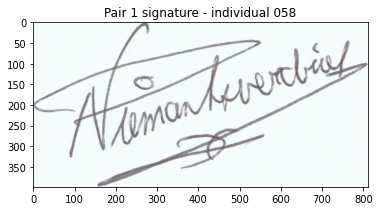

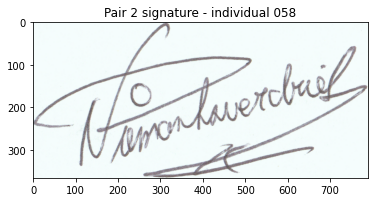

In [ ]:
pair_1 = df_test.iloc[800, 0]
pair_2 = df_test.iloc[800, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 058")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 058")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 050/03_050.png
Image label: Forgery 050_forg/04_0125050.PNG
[[0.41213536 0.5878647 ]]
1
Not Similar


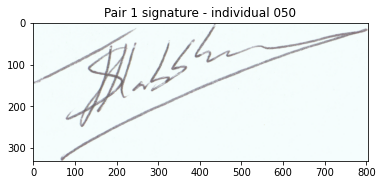

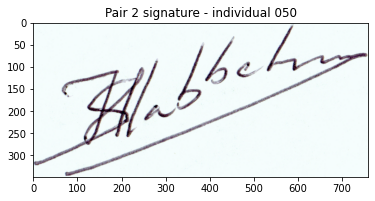

In [ ]:
pair_1 = df_test.iloc[1600, 0]
pair_2 = df_test.iloc[1600, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 050")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 050")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

## Next, I'll try to include Batch Normalization and Drop Out into the next model to improve overfitting. 


Batch normalization will be tried out in this model, it is added between the layers of the neural network and it continuously takes the output from the previous layer and normalizes it before sending it to the next layer. This has the effect of stabilizing the neural network. Batch normalization is also used to maintain the distribution of the data.


Furthermore, Dropout was used as a way to prevent neural networks from overfitting. Dropout works by randomly disabling neurons and their corresponding connections. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better. DropOut will make the network more robust. By removing different neurons on every pass through the network. The networks are trained with different compositions of neurons and averaging their results.

In [ ]:
def build_base_network(input_shape):
    seq = Sequential()

    kernel_size = 3

    seq.add(Convolution2D(64, (kernel_size, kernel_size), input_shape=input_shape))
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.4))

    seq.add(Convolution2D(32, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.4))

    # flatten
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(BatchNormalization())
    seq.add(Dropout(0.3))
    seq.add(Dense(64, activation='relu'))
    return seq

In [ ]:
input_dim = (100, 100, 1)
base_network = build_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
vec_a = base_network(img_a)
vec_b = base_network(img_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vec_a, vec_b])

prediction = Dense(2, activation='softmax')(distance)


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model = Model([img_a, img_b], prediction)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           2195168     ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

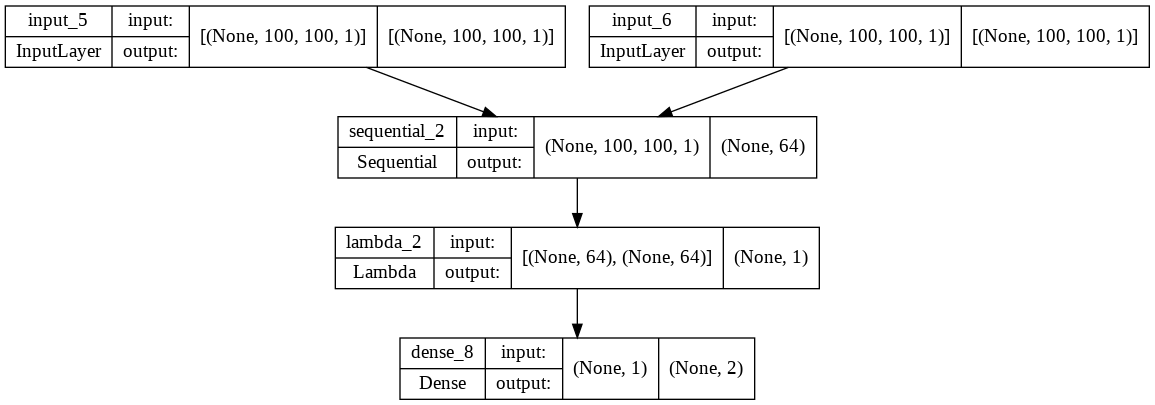

In [ ]:
plot_model(model, to_file='model_plotwithbatchnormalizationanddropout.png', show_shapes=True, show_layer_names=True)

In [ ]:


adam = tf.keras.optimizers.Adam(learning_rate=0.00008)

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])


In [ ]:
history = model.fit([train_images1,train_images2], train_labels, validation_split=.3, ##change to 0.3
      batch_size= 128, verbose = 1, epochs=40)

Epoch 1/40
127/127 [==============================] - 13s 87ms/step - loss: 3.4751 - accuracy: 0.4581 - val_loss: 0.6816 - val_accuracy: 0.4543
Epoch 2/40
127/127 [==============================] - 10s 79ms/step - loss: 2.1152 - accuracy: 0.4581 - val_loss: 1.8788 - val_accuracy: 0.4546
Epoch 3/40
127/127 [==============================] - 10s 79ms/step - loss: 1.5163 - accuracy: 0.4581 - val_loss: 0.6523 - val_accuracy: 0.5037
Epoch 4/40
127/127 [==============================] - 10s 79ms/step - loss: 1.1755 - accuracy: 0.4581 - val_loss: 0.6358 - val_accuracy: 0.5496
Epoch 5/40
127/127 [==============================] - 10s 79ms/step - loss: 0.9942 - accuracy: 0.4581 - val_loss: 0.6677 - val_accuracy: 0.6718
Epoch 6/40
127/127 [==============================] - 10s 79ms/step - loss: 0.8847 - accuracy: 0.4582 - val_loss: 1.2087 - val_accuracy: 0.6953
Epoch 7/40
127/127 [==============================] - 10s 79ms/step - loss: 0.8116 - accuracy: 0.4584 - val_loss: 4.9534 - val_accuracy:

In [ ]:
model.save('model.h5')

In [ ]:
pred_y = model.predict([test_images1,test_images2])
predict = np.argmax(pred_y, axis =1 )
accuracy_score(predict , test_labels)

0.9498956158663883

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(test_labels, pred_y.argmax(axis=1))
print('Acc: {:.4f}'.format(acc))

Acc: 0.9499


In [ ]:
cf_matrix = confusion_matrix(test_labels, pred_y.argmax(axis=1))
print(confusion_matrix(test_labels, pred_y.argmax(axis=1)))

[[2772    0]
 [ 288 2688]]


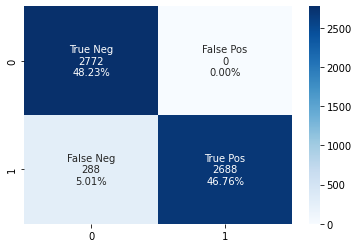

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

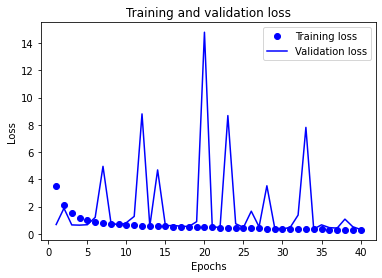

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


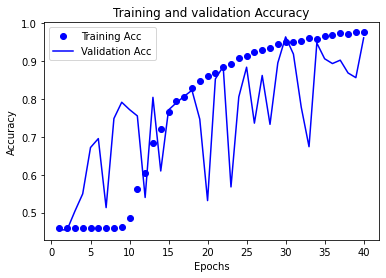

In [ ]:
history_dict = history.history
loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, (len(history.history['accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training Acc')
plt.plot(epochs, val_loss_values, 'b', label='Validation Acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 The model is still overfitting as the training accuracy is till performing better than val accuracy. Furthermore, val loss and val accuracy is looking very jumpy. This could be due to the batch normalization as  each batch coming through changes theneural network considerably as it does not have enough neurons to represent the relationships.

 




## Testing model on sample images

Image label: Genuine 068/09_068.png
Image label: Forgery 068_forg/03_0113068.PNG
[[0.02726717 0.97273284]]
1
Not Similar


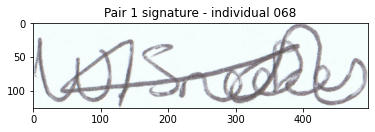

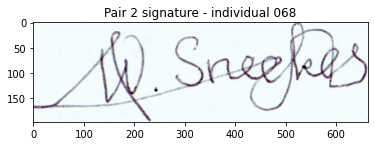

In [ ]:
pair_1 = df_test.iloc[0, 0]
pair_2 = df_test.iloc[0, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 068")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 068")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 067/07_067.png
Image label: Genuine 067/04_067.png
[[0.657125   0.34287497]]
0
Similar


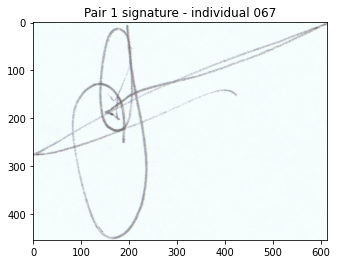

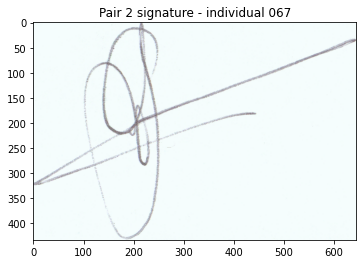

In [ ]:
pair_1 = df_test.iloc[1200, 0]
pair_2 = df_test.iloc[1200, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 067")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 067")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 058/04_058.png
Image label: Genuine 058/03_058.png
[[0.657125   0.34287497]]
0
Similar


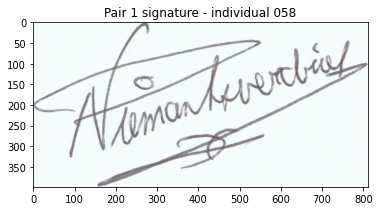

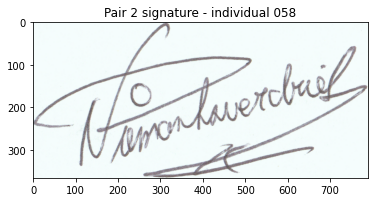

In [ ]:
pair_1 = df_test.iloc[800, 0]
pair_2 = df_test.iloc[800, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 058")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 058")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 050/03_050.png
Image label: Forgery 050_forg/04_0125050.PNG
[[0.00373081 0.9962692 ]]
1
Not Similar


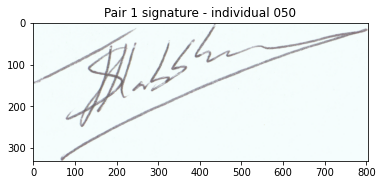

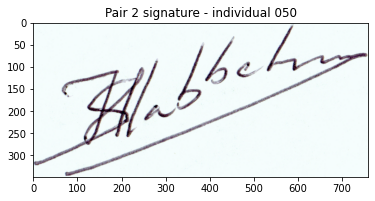

In [ ]:
pair_1 = df_test.iloc[1600, 0]
pair_2 = df_test.iloc[1600, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 050")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 050")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 050/03_050.png
Image label: Genuine 068/02_068.png
[[0.657125   0.34287497]]
0
Similar


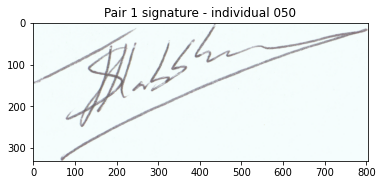

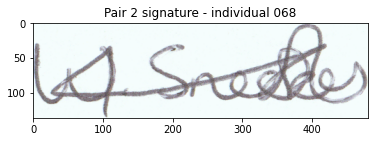

In [ ]:
pair_1 = df_test.iloc[1600, 0]
pair_2 = df_test.iloc[152, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 050")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 068")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

Image label: Genuine 068/10_068.png
Image label: Forgery 050_forg/04_0125050.PNG
[[0.00373081 0.9962692 ]]
1
Not Similar


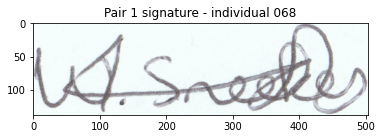

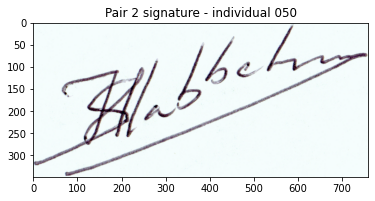

In [ ]:
pair_1 = df_test.iloc[134, 0]
pair_2 = df_test.iloc[1600, 1]
pair1_path = '/content/sign/sign_data/test/'+pair_1
pair2_path = '/content/sign/sign_data/test/'+pair_2

two_label = [pair_1, pair_2]

for x in two_label:
  if "forg" in x: 
    print('Image label: Forgery', x)
  else:
    print('Image label: Genuine', x)


pair_1read = plt.imread('/content/sign/sign_data/test/'+pair_1)
pair_2read = plt.imread('/content/sign/sign_data/test/'+pair_2)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_1read)
plt.title("Pair 1 signature - individual 068")

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(pair_2read)
plt.title("Pair 2 signature - individual 050")

x = image.load_img(pair1_path, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
y = image.load_img(pair2_path, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)
if y_pred==1:
  print('Not Similar')
else:
  print('Similar')

# These two model were able to correctly predict these sample images.

# 5 Conclusion and recommendations

Overfitting is a huge issue with my model, I have to address this problem. One way in which I can work with this is to develop a GAN Model to generate more data, using generative adversarial networks to study handwritten signature identification.

Alternatively, more time will be required to explore and try out methods in which to address overfitting. E.g. Data Augmentation or GAN to improve my model. Furthermore, I can source out places in which to obtain datasets with more data on signatures.


Use cases for in identifying forged signatures will be very useful in further applications in online signatures as well. How are we able to apply the knowledge from identifying handwritten signatures to online signatures. This would help address the validity of e-signatures, which is one of the considerations of why handwritten signatures are still preferred for transactions of great importance like a will. 

